In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf 


print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from attention import Attention_Block
# from attention import attention_block
from tensorflow.keras.layers import Attention
from step_attention import AttentionAugmentation2D, _normalize_depth_vars
# from keras.models import load_model

# In[2]:


# from google.colab import drive
# drive.mount('/content/drive')



# In[3]:


from loss import discounted_l1, max_displacement_error,v3_displacement_error
import math
import pickle5 as pickle
import matplotlib.pyplot as plt
from numpy import array
# import horovod.tensorflow.keras as hvd

2.2.0


In [2]:

# hvd.init()

# In[4]:

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"


gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)


if gpus:
    
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except:
        print('checking gpu error')
print('checking GPUs')


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=tf.compat.v1.ConfigProto()
# config.gpu_options.visible_device_list= '0,1'
config.gpu_options.allow_growth=True

config.log_device_placement=True
# config.visible_device_list =2
sess=tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)


# In[5]:


from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from load_data import load_data
import os

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
checking gpu error
checking GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:09:00.0, compute capability: 6.1



In [3]:




# train_X_route = '/home/lab1/repo/lyft/newarray/training_features_vehicle.npy'
# # test_route = home+'/repo/data/X_to_val.npy'

# train_y_route = '/home/lab1/repo/lyft/newarray/training_labels_vehicle.npy'
# test_y_route = home+'/repo/data/y_to_val.npy'
prefix ='/home/lab1/repo/planning/traj_pred/data/'
train_raw, test_raw=None, None
for i in range(3):
    name_tr= prefix+'ped_train_set_'+str(i)+'.npy'
    name_te= prefix+'ped_test_set_'+str(i)+'.npy'
    tr = np.load(name_tr,allow_pickle=True).astype(float)
    te = np.load(name_te,allow_pickle=True).astype(float)
    if train_raw is None:
        train_raw=tr
    else:
        train_raw= np.vstack((train_raw, tr))
    
    if test_raw is None:
        test_raw=te
    else:
        test_raw= np.vstack((test_raw, te))

print(train_raw.shape, test_raw.shape)




(824980, 11, 4) (20626, 20, 4)


In [10]:
np.random.shuffle(train_raw)
np.random.shuffle(test_raw)
if len(train_raw)>300000:
    max_n=300000
else:
    max_n=len(train_raw)
test_maxn=int(max_n*0.4)
train_set = train_raw[:max_n]
X_train=train_set[:,:10,2:4]
y_train=train_set[:,10,2:4]

test_set = test_raw[:test_maxn]
X_test=test_set[:,:10,2:4]
y_test=test_set[:,10,2:4]
y = test_set[:,10:,2:4]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, y.shape)

(300000, 10, 2) (300000, 2) (20626, 10, 2) (20626, 2) (20626, 10, 2)


In [11]:
# print(X_position.shape, y.shape, X.shape)
print(X_train.shape, y_train.shape)
print(y_train[0])

(300000, 10, 2) (300000, 2)
[ 21.18670654 -12.80273438]


In [12]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_train, X_val, y_train, y_val= \
train_test_split(X_train, y_train,test_size=0.1, random_state=1)

# X_val, X_test, y_val, y_test= \
# train_test_split(X_test, y_test,test_size=0.5, random_state=1)

print(X_val.shape, y_val.shape, X_train.shape, X_test.shape)

(30000, 10, 2) (30000, 2) (270000, 10, 2) (20626, 10, 2)


In [13]:

from pathlib import Path
home = str(Path.home())

In [14]:

# In[9]:


filters=20
kernel_size = (3,3)
strides = (1,1)
depth_k =0.2
depth_v =0.2

channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
print("before normalized k, v",depth_k,depth_k,strides)
depth_k, depth_v = _normalize_depth_vars(depth_k, depth_v, filters)
print("after normalized k, v",depth_k,depth_k,strides)


# In[10]:
time_step=10
tf.compat.v1.disable_eager_execution()

rnn = Sequential()
rnn.add(LSTM(128, return_sequences=True, kernel_regularizer='l1', input_shape=(time_step,2)))
rnn.add(LSTM(256, return_sequences=True, kernel_regularizer='l1',input_shape=(time_step,128)))
rnn.add(Reshape((time_step,16,16,1)))
rnn.summary()



cnn = Sequential()

cnn.add(Conv2D(1024, (4, 4),input_shape=(16, 16, 1)))
cnn.add(Conv2D(512, (2, 2)))
cnn.add(Conv2D(256, (4, 4)))
cnn.add(Conv2D(128, (2, 2)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(64, (2, 2)))
cnn.add(Conv2D(32, (2, 2)))
cnn.add(Conv2D(16, (2, 2)))

#attention block below
cnn.add(Conv2D(2 * depth_k + depth_k, (1, 1), strides))
cnn.add(AttentionAugmentation2D(depth_k, depth_v, num_heads=4, relative=True))

# cnn.add(Dropout(0.5))
cnn.add(Flatten())

 
cnn.add(Dense(128))
cnn.add(Dense(32))

cnn.summary() 



rnn2=Sequential()
rnn2.add(GRU(256, input_shape=(time_step,32)))


dense = Sequential()
dense.add(Dense(128))
dense.add(Dense(64))
dense.add(Dense(2)) # Model output

main_input = Input(shape=(time_step,2)) 
model = rnn(main_input)
model = TimeDistributed(cnn)(model) 
 # combine timedistributed cnn, attention, and fully connected network with rnn
model = rnn2(model)
model = dense(model) # add dense
final_model = Model(inputs=main_input, outputs=model)
final_model.summary()


before normalized k, v 0.2 0.2 (1, 1)
after normalized k, v 4 4 (1, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
reshape (Reshape)            (None, 10, 16, 16, 1)     0         
Total params: 461,312
Trainable params: 461,312
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 1024)      17408     
________

In [13]:
# print(home)

In [15]:


n_batch = 32
n_epoch  = 150


checkpoint_path =home+ "/repo/planning/traj_pred/ped_models/ped_{epoch}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


 #(None, n_steps, n_features)

sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.5, nesterov=True)
rmsprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)



ftrl = tf.keras.optimizers.Ftrl(learning_rate=0.01)


mtrc = [tf.keras.metrics.MeanAbsoluteError()]
# [tf.keras.metrics.CosineSimilarity(axis=1)]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.95)

adagrad = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)

# to use customized loss, choose from  discounted_l1 or max_displacement_error function as loss parameter 
final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('/home/lab1/repo/models/lyft_vehicles/vehicles2_16.h5')

history=final_model.fit(X_train, 
                        y_train, epochs=n_epoch, 
                        batch_size=n_batch, 
                        verbose=2, 
                        validation_data=(X_val, y_val),
                        callbacks=[cp_callback])





Train on 270000 samples, validate on 30000 samples
Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.84707, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_1.h5
270000/270000 - 1110s - loss: 1.7578 - mean_absolute_error: 0.3147 - val_loss: 0.8471 - val_mean_absolute_error: 0.2739
Epoch 2/150

Epoch 00002: val_loss improved from 0.84707 to 0.71129, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_2.h5
270000/270000 - 1144s - loss: 0.7019 - mean_absolute_error: 0.1729 - val_loss: 0.7113 - val_mean_absolute_error: 0.1711
Epoch 3/150

Epoch 00003: val_loss did not improve from 0.71129
270000/270000 - 1145s - loss: 0.6985 - mean_absolute_error: 0.1473 - val_loss: 0.7962 - val_mean_absolute_error: 0.1865
Epoch 4/150

Epoch 00004: val_loss improved from 0.71129 to 0.68806, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_4.h5
270000/270000 - 1147s - loss: 0.6912 - mean_absolute_error: 0.1321 - val_loss: 0.6881 - val_mean_absolute_err

Epoch 36/150

Epoch 00036: val_loss improved from 0.23576 to 0.23148, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_36.h5
270000/270000 - 1160s - loss: 0.2368 - mean_absolute_error: 0.0573 - val_loss: 0.2315 - val_mean_absolute_error: 0.0562
Epoch 37/150

Epoch 00037: val_loss improved from 0.23148 to 0.22169, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_37.h5
270000/270000 - 1161s - loss: 0.2302 - mean_absolute_error: 0.0569 - val_loss: 0.2217 - val_mean_absolute_error: 0.0536
Epoch 38/150

Epoch 00038: val_loss improved from 0.22169 to 0.21955, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_38.h5
270000/270000 - 1159s - loss: 0.2239 - mean_absolute_error: 0.0565 - val_loss: 0.2196 - val_mean_absolute_error: 0.0556
Epoch 39/150

Epoch 00039: val_loss did not improve from 0.21955
270000/270000 - 1161s - loss: 0.2181 - mean_absolute_error: 0.0562 - val_loss: 0.2277 - val_mean_absolute_error: 0.0644
Epoch 40/150

Epoch 00040: va

Epoch 70/150

Epoch 00070: val_loss improved from 0.12004 to 0.11986, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_70.h5
270000/270000 - 1201s - loss: 0.1198 - mean_absolute_error: 0.0514 - val_loss: 0.1199 - val_mean_absolute_error: 0.0518
Epoch 71/150

Epoch 00071: val_loss improved from 0.11986 to 0.11844, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_71.h5
270000/270000 - 1200s - loss: 0.1183 - mean_absolute_error: 0.0513 - val_loss: 0.1184 - val_mean_absolute_error: 0.0519
Epoch 72/150

Epoch 00072: val_loss improved from 0.11844 to 0.11662, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_72.h5
270000/270000 - 1194s - loss: 0.1169 - mean_absolute_error: 0.0512 - val_loss: 0.1166 - val_mean_absolute_error: 0.0516
Epoch 73/150

Epoch 00073: val_loss improved from 0.11662 to 0.11591, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_73.h5
270000/270000 - 1197s - loss: 0.1156 - mean_absolute_error: 0.0512 - val


Epoch 00103: val_loss improved from 0.09362 to 0.09321, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_103.h5
270000/270000 - 1219s - loss: 0.0932 - mean_absolute_error: 0.0500 - val_loss: 0.0932 - val_mean_absolute_error: 0.0502
Epoch 104/150

Epoch 00104: val_loss improved from 0.09321 to 0.09294, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_104.h5
270000/270000 - 1222s - loss: 0.0929 - mean_absolute_error: 0.0500 - val_loss: 0.0929 - val_mean_absolute_error: 0.0502
Epoch 105/150

Epoch 00105: val_loss improved from 0.09294 to 0.09277, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_105.h5
270000/270000 - 1226s - loss: 0.0925 - mean_absolute_error: 0.0500 - val_loss: 0.0928 - val_mean_absolute_error: 0.0503
Epoch 106/150

Epoch 00106: val_loss improved from 0.09277 to 0.09243, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_106.h5
270000/270000 - 1220s - loss: 0.0922 - mean_absolute_error: 0.0499 - val_loss:

Epoch 135/150

Epoch 00135: val_loss improved from 0.08741 to 0.08734, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_135.h5
270000/270000 - 1159s - loss: 0.0870 - mean_absolute_error: 0.0497 - val_loss: 0.0873 - val_mean_absolute_error: 0.0500
Epoch 136/150

Epoch 00136: val_loss improved from 0.08734 to 0.08727, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_136.h5
270000/270000 - 1078s - loss: 0.0869 - mean_absolute_error: 0.0497 - val_loss: 0.0873 - val_mean_absolute_error: 0.0500
Epoch 137/150

Epoch 00137: val_loss improved from 0.08727 to 0.08718, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_137.h5
270000/270000 - 1077s - loss: 0.0868 - mean_absolute_error: 0.0496 - val_loss: 0.0872 - val_mean_absolute_error: 0.0500
Epoch 138/150

Epoch 00138: val_loss improved from 0.08718 to 0.08717, saving model to /home/lab1/repo/planning/traj_pred/ped_models/ped_138.h5
270000/270000 - 1077s - loss: 0.0867 - mean_absolute_error: 0.04

In [16]:
print("Evaluate on test data")
results = final_model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


_history_path = home+ '/repo/planning/traj_pred/total_model_history/ped_history.sav'
pickle.dump(history.history, open(_history_path, 'wb'))

_weights_path =  home+ '/repo/planning/traj_pred/total_model_history/ped_weights.h5'
final_model.save_weights(_weights_path)


Evaluate on test data
test loss, test acc: [0.08582995611114806, 0.049548995]


In [11]:
################################DONE

In [17]:
# In[ ]:
# X_val, X_test, y_val, y_test,X_train, , y_train, 
np.save("p_xval",X_val)
np.save('p_yval',y_val)
np.save("p_xtrain",X_train)
np.save("p_ytrain",y_train)
np.save("p_xtest",X_test)
np.save("p_ytest",y_test)
np.save("p_y",y)

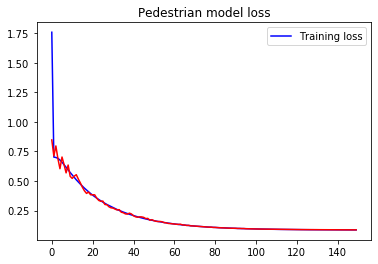

In [18]:
history.history.keys()
ax1,=plt.plot( history.history['loss'], c='b', label='Training loss')
ax2,=plt.plot( history.history['val_loss'], c='r', label='Validation loss')

plt.legend(handles=[ax1,ax2])
plt.title('Pedestrian model loss')
plt.show()

In [ ]:
# final_model.compile(loss=v3_displacement_error, optimizer=adadelta, metrics=mtrc)
# final_model.load_weights('home+ '/repo/planning/traj_pred/total_model_history/veh_weights.h5'')

In [ ]:
# ##prediction
# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,50):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# # i= np.random.randint(0, len(X_test))
# # results = get_sequence_prediction(X_test, i)
# # print(results.shape)

# test=np.load('vehicle_test_history.npy')
# v_predict=[]
# print(len(test))
# for i in range(len(test)):
#     print(i)
#     results = get_sequence_prediction(test, i)
#     v_predict.append(results)
# np.save("v_predictions",v_predict)

# print('done')

In [ ]:
# print(np.array(v_predict).shape)
# np.save("v_predictions",v_predict)
# print('done')

In [ ]:
# i= np.random.randint(0, len(X_test))


# # In[ ]:
# # i =2273

# # i=1574
# # i=3070

# # i=387,39
# # i=667
# # i=15
# print("showing trip", i)


# # from utilities import get_position_sequence
# def get_position_sequence(prev, new):
#     arr = np.delete(prev, 0, 0)
#     a=np.vstack((arr,new))
#     return a 

# def get_sequence_prediction(X_position_test, i):
#     results =[]
#     s=X_position_test[i]
#     for count in range(0,12):
        
#         result = final_model.predict(np.array([s]))
# #         print(result)
#         results.append(result[0])
#         s = get_position_sequence(s, result)
#     results=np.array(results)
# #     print(s.shape,results.shape)
    
#     return results

# results = get_sequence_prediction(X_test, i)

# # print(len(results))
# # print("sss",results)

# ax1 =plt.scatter(y_test[i][:,0],y_test[i][:,1],color='b',label='Ground truth')

# ax2 =plt.scatter(X_test[i][:,0],X_test[i][:,1],color='r', label='Training segment')


# ax3 =plt.scatter(results[:,0],results[:,1],color='g', label='Prediction')
# # ax3 =plt.scatter(result[0][0],result[0][1],color='g', label='Prediction')

# plt.legend(handles=[ax1, ax2, ax3])
# plt.show()

# distance = v3_displacement_error(results,y_test[i] )
# avg = K.mean(distance)
# pl =[]
# # tf.print(distance,output_stream=sys.stderr)
# with tf.compat.v1.Session() as sess: pl=distance.eval(), print(distance.eval(),'\naverage',avg.eval()) 
# import matplotlib.pyplot as plt
# # print(pl[0])
# plt.plot(pl[0])
# plt.title('Displacement error')
# plt.show()

In [ ]:
# final_displacement=[]
# avg_displacement=[]

# # for idx in range(0,len(X_test)):
# for idx in range(0,1000):
#     p=[]
#     re= get_sequence_prediction(X_test, idx)
#     distance = v3_displacement_error(re,y_test[idx] )
#     avg = K.mean(distance)
    
#     with tf.compat.v1.Session() as sess:
#         p=distance.eval()
#         ax =avg.eval()
# #     print(p,ax)
#     final_displacement.append(p)
#     avg_displacement.append(ax)

# final_displacement = np.array(final_displacement)
# sec=[]

# for j in range(0,final_displacement.shape[1]):
#     displacement = sum(final_displacement[:,j])/len(final_displacement)
    
#     sec.append(displacement)
# print("Final displacement error:",sec[-1])
# print("Average displacement error:",sum(avg_displacement)/len(avg_displacement))

# print(sec)
# plt.plot(sec)
# plt.title("average displacement error at each timestep")
# plt.show()



In [ ]:
# history2 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta_600.sav',  "rb") ) 
# history3 = pickle.load(open( cwd+ '/saved_model/lab1_txt_max_history_mae_adadelta.sav',  "rb") )
# print(len(history.history['loss']))
# # plt.plot(range(600,1100),history.history['loss'], c='b')
# # plt.plot( range(300,600), history2['loss'], c='b')
# plt.plot( history3['loss'], c='b')
# plt.title('train loss')

# # plt.plot(range(600,1100),history.history['val_loss'], c='r')
# # plt.plot( range(300,600), history2['val_loss'], c='r')
# plt.plot( history3['val_loss'], c='r')
# plt.title('loss')


# plt.show()